Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.94
Precision: 0.95
Recall: 0.95
F1 Score: 0.95

Classification Report:
               precision    recall  f1-score   support

  No Disease       0.93      0.93      0.93        40
 Has Disease       0.95      0.95      0.95        60

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100

Confusion Matrix:
 [[37  3]
 [ 3 57]]


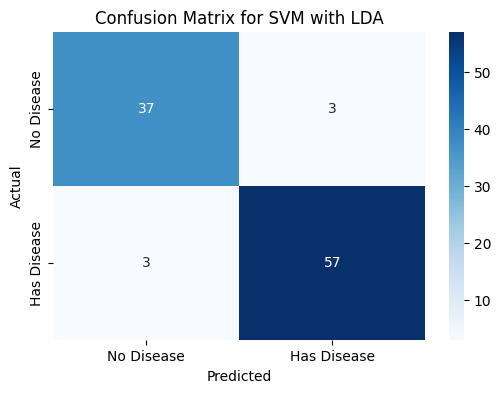

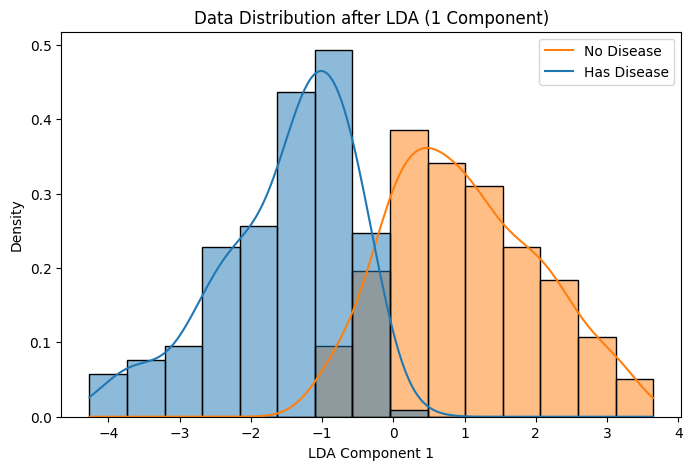

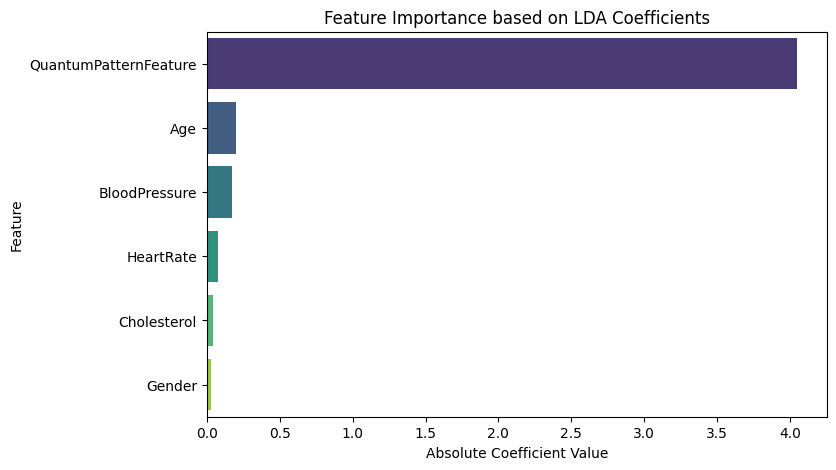

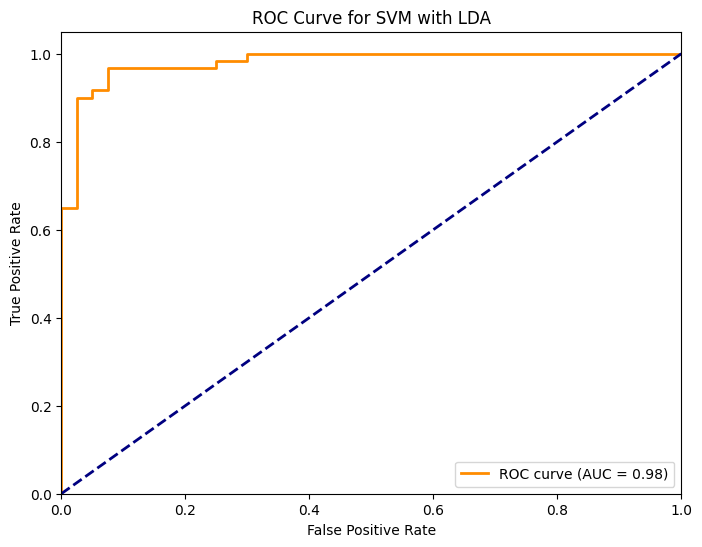

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Đọc dữ liệu
data = pd.read_csv('Heart Prediction Quantum Dataset.csv')

# Tiền xử lý dữ liệu
# Kiểm tra giá trị thiếu
if data.isnull().sum().any():
    data = data.dropna()

# Tách đặc trưng và nhãn
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Áp dụng LDA để giảm chiều
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_scaled, y)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)

# Khởi tạo mô hình SVM
svm = SVC(random_state=42, probability=True)

# Định nghĩa lưới tham số cho Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'degree': [2, 3]
}

# Tối ưu hóa siêu tham số với Grid Search
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_svm = grid_search.best_estimator_

# Dự đoán trên tập kiểm tra
y_pred = best_svm.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# In kết quả
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['No Disease', 'Has Disease']))
print("Confusion Matrix:\n", conf_matrix)

# Trực quan hóa ma trận nhầm lẫn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Has Disease'],
            yticklabels=['No Disease', 'Has Disease'])
plt.title('Confusion Matrix for SVM with LDA')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Trực quan hóa dữ liệu sau LDA (1 chiều)
plt.figure(figsize=(8, 5))
sns.histplot(x=X_lda.flatten(), hue=y, stat='density', common_norm=False, kde=True)
plt.title('Data Distribution after LDA (1 Component)')
plt.xlabel('LDA Component 1')
plt.ylabel('Density')
plt.legend(labels=['No Disease', 'Has Disease'])
plt.show()

# Trực quan hóa tầm quan trọng đặc trưng dựa trên hệ số LDA
feature_importance = pd.DataFrame({
    'Feature': data.drop('HeartDisease', axis=1).columns,
    'Coefficient': np.abs(lda.coef_[0])
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance based on LDA Coefficients')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Trực quan hóa ROC Curve
y_pred_proba = best_svm.predict_proba(X_test)[:, 1]  # Xác suất lớp 1 (Has Disease)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM with LDA')
plt.legend(loc='lower right')
plt.show()